In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epl-with-labels-matchday/EPL.csv
/kaggle/input/laliga-dataset-csv/all_laliga_matches_2014_2024.csv
/kaggle/input/club-football-match-data-2000-2025/Matches.csv
/kaggle/input/club-football-match-data-2000-2025/EloRatings.csv
/kaggle/input/final-df-prem/final_df_prem.csv
/kaggle/input/epl-dataset-csv/EPL.csv


# *DATA PREPROCESSING AND FEATURE ENGINEERING* 

In [190]:
def preprocess_data(path):
    """
    Preprocess the data by loading it from a CSV file, renaming columns, and converting data types.
    """
    df = pd.read_csv(path)
    df.sort_values(['date'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['result'] = pd.to_numeric(df['result'].replace({'w': 3, 'd': 1, 'l': 0}), errors='coerce')
    df['result'] = df['result'].fillna(0).round().astype(int)
    df.head(20)

    # Safe division function
    def safe_divide(a, b):
        return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

    # Create team views with safe calculations
    team_cols = ['date', 'team', 'team_form', 'xG', 'shots', 'shotOnTarget', 'deep', 'is_home', 'possession_proxy', 'final_pos']
    df['home_result'] = np.where(df['home_goals'] > df['away_goals'], 3,
                      np.where(df['home_goals'] == df['away_goals'], 1, 0))
    df['away_result'] = np.where(df['away_goals'] > df['home_goals'], 3,
                      np.where(df['away_goals'] == df['home_goals'], 1, 0))
    df_home = df.assign(
        team=df['home_team'],
        team_form=df['home_result'],
        is_home=1,
        final_pos= df['home_final_pos'],
        possession_proxy=(
            0.3 * safe_divide(df['xG_home'], df['xG_home']+df['xG_away']) +
            0.3 * safe_divide(df['home_shots'], df['home_shots']+df['away_shots']) +
            0.4 * safe_divide(df['home_deep'], df['home_deep']+df['away_deep'])
        )
    ).rename(columns={
        'xG_home': 'xG',
        'home_shots': 'shots',
        'home_shotOnTarget': 'shotOnTarget',
        'home_deep': 'deep'
    })[team_cols]

    df_away = df.assign(
        team=df['away_team'],
        team_form=df['away_result'],
        is_home=0,
        final_pos= df['away_final_pos'],
        possession_proxy=(
            0.3 * safe_divide(df['xG_away'], df['xG_home']+df['xG_away']) +
            0.3 * safe_divide(df['away_shots'], df['home_shots']+df['away_shots']) +
            0.4 * safe_divide(df['away_deep'], df['home_deep']+df['away_deep'])
        )
    ).rename(columns={
        'xG_away': 'xG',
        'away_shots': 'shots',
        'away_shotOnTarget': 'shotOnTarget',
        'away_deep': 'deep'
    })[team_cols]

    # Combine and sort
    df_team = pd.concat([df_home, df_away]).sort_values(['team','date']).reset_index(drop=True)

    # Calculate rolling features
    stats = ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']
    for stat in stats:
        df_team[f'rolling_{stat}'] = (
            df_team.groupby('team')[stat]
            .transform(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))
            # Optional: fill initial NaN per team
            .fillna(0)
        )
    return df_team, df


In [191]:
team_df, match_df = preprocess_data('/kaggle/input/laliga-dataset-csv/all_laliga_matches_2014_2024.csv')
team_df.groupby('team', as_index=False).head(50)
# match_df.head(5)

/tmp/ipykernel_31/3902995959.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = pd.to_numeric(df['result'].replace({'w': 3, 'd': 1, 'l': 0}), errors='coerce')
/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
0,2016-08-22,Alaves,1,0.033222,2,1,0,0,0.002366,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-08-28,Alaves,1,1.120170,13,2,2,1,0.240531,9,0.033222,2.000000,1.000000,0.000000,1.000000,0.002366
2,2016-09-10,Alaves,3,0.290172,5,4,0,0,0.053010,9,0.576696,7.500000,1.500000,1.000000,1.000000,0.121449
3,2016-09-19,Alaves,1,0.459330,9,1,5,1,0.121826,9,0.481188,6.666667,2.333333,0.666667,1.666667,0.098636
4,2016-09-23,Alaves,0,0.259625,8,1,2,0,0.046307,9,0.475723,7.250000,2.000000,1.750000,1.500000,0.104433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7911,2015-10-18,Villarreal,0,0.995361,12,3,4,1,0.113997,4,1.004321,7.800000,3.800000,5.000000,2.400000,0.148222
7912,2015-10-25,Villarreal,1,0.205133,5,0,2,0,0.156137,4,0.905910,8.600000,3.400000,4.600000,1.800000,0.132302
7913,2015-10-31,Villarreal,3,1.033370,11,5,10,1,0.161942,4,0.623988,6.800000,2.000000,3.400000,1.400000,0.129875
7914,2015-11-08,Villarreal,0,0.278588,5,2,1,0,0.024907,4,0.643949,7.200000,2.400000,4.400000,1.400000,0.131348


In [192]:
def merge(match_df, team_df):
    # print(team_df.columns.tolist())
    prepared_df = match_df.merge(
        team_df[team_df['is_home']==1][['date', 'team', *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]],
        left_on=['date', 'home_team'],
        right_on=['date', 'team'],
        suffixes=('', '_home')
    )
    prepared_df = prepared_df.merge(
        team_df[team_df['is_home']==0][['date', 'team', *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]],
        left_on=['date', 'away_team'],
        right_on=['date', 'team'],
        suffixes=('', '_away')
    )
    return prepared_df



In [193]:
prepared_df = merge(match_df, team_df)
prepared_df.head(10).filter(['team', 'date', 'xG', 'rolling_team_form', 'team_form', 'final_pos'])

,team,date,rolling_team_form
0,Sevilla,2014-08-23,0.0
1,Malaga,2014-08-23,0.0
2,Granada,2014-08-23,0.0
3,Almeria,2014-08-23,0.0
4,Barcelona,2014-08-24,0.0
5,Levante,2014-08-24,0.0
6,Celta Vigo,2014-08-24,0.0
7,Eibar,2014-08-24,0.0
8,Real Madrid,2014-08-25,0.0
9,Rayo Vallecano,2014-08-25,0.0


In [194]:
elo_df = pd.read_csv('/kaggle/input/club-football-match-data-2000-2025/EloRatings.csv')
elo_df['date'] = pd.to_datetime(elo_df['date'])  # Convert first if needed
elo_df[
    (elo_df['country'] == "ENG") & 
    (elo_df['date'].dt.year == 2020) & (elo_df['club'] == "Tottenham")
]


,date,club,country,elo
191539,2020-01-01,Tottenham,ENG,1840.87
191946,2020-01-15,Tottenham,ENG,1826.59
192352,2020-02-01,Tottenham,ENG,1826.54
192758,2020-02-15,Tottenham,ENG,1842.44
193164,2020-03-01,Tottenham,ENG,1828.44
193570,2020-03-15,Tottenham,ENG,1798.41
193976,2020-04-01,Tottenham,ENG,1798.41
194382,2020-04-15,Tottenham,ENG,1798.41
194788,2020-05-01,Tottenham,ENG,1798.41
195194,2020-05-15,Tottenham,ENG,1798.41


In [195]:
from scipy.special import expit as sigmoid

# Configuration
k = 400  # Elo rating scale factor
elo_baseline = 1500  # Baseline Elo rating
stats_cols = ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']
# 1. Prepare the base statistics (using year-specific means)
def get_year_specific_base_stats(year):
    year_mask = (team_df['date'].dt.year == year)
    return {
        'xG': team_df.loc[year_mask, 'rolling_xG'].mean(),
        'shots': team_df.loc[year_mask, 'rolling_shots'].mean(),
        'shotOnTarget': team_df.loc[year_mask, 'rolling_shotOnTarget'].mean(),
        'deep': team_df.loc[year_mask, 'rolling_deep'].mean(),
        'team_form': team_df.loc[year_mask, 'rolling_team_form'].mean(),
        'possession_proxy': team_df.loc[year_mask, 'rolling_possession_proxy'].mean()
    }

# 2. Define the imputation function
def elo_impute(base_stat, elo_team, k=400, elo_baseline=1500):
    return base_stat * (1 + sigmoid((elo_team - elo_baseline) / k))

# 3. Process each row that needs imputation
for idx, row in team_df.iterrows():
    if all(row[f'rolling_{col}'] == 0 for col in stats_cols):  # Check if any rolling stat is 0
        year = row['date'].year
        team = row['team']
        
        # Get year-specific base stats
        base_stats = get_year_specific_base_stats(year)
        
       # Find team's Elo rating (most recent before current date)
        filtered_elo = elo_df[
            (elo_df['club'] == team) & 
            (elo_df['date'] <= row['date'])
        ].sort_values('date', ascending=False)

        # Use baseline if no past Elo found
        team_elo = filtered_elo['elo'].values[0] if not filtered_elo.empty else elo_baseline
        
        # Impute each stat
        for stat in stats_cols:
            if row[f'rolling_{stat}'] == 0:
                base_stat = base_stats[stat]
                team_df.at[idx, f'rolling_{stat}'] = elo_impute(base_stat, team_elo, k, elo_baseline)

In [196]:
team_df[team_df['team'] == "Barcelona"].head(50)

,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
1242,2014-08-24,Barcelona,3,1.541240,12,6,12,1,0.680348,1,2.080825,19.591600,6.882895,7.751267,2.311728,0.305611
1243,2014-08-31,Barcelona,3,3.125450,20,8,11,0,0.221464,1,1.541240,12.000000,6.000000,12.000000,3.000000,0.680348
1244,2014-09-13,Barcelona,3,2.177200,14,8,14,1,0.287082,1,2.333345,16.000000,7.000000,11.500000,3.000000,0.450906
1245,2014-09-21,Barcelona,3,3.822900,17,8,14,0,0.668910,1,2.281297,15.333333,7.333333,12.333333,3.000000,0.396298
1246,2014-09-24,Barcelona,1,0.646364,10,0,7,0,0.209627,1,2.666698,15.750000,7.500000,12.750000,3.000000,0.464451
1247,2014-09-27,Barcelona,3,4.927580,19,12,16,1,0.675138,1,2.262631,14.600000,6.000000,11.600000,2.600000,0.413486
1248,2014-10-04,Barcelona,3,2.978340,18,7,12,0,0.255729,1,2.939899,16.000000,7.200000,12.400000,2.600000,0.412444
1249,2014-10-18,Barcelona,3,3.092940,27,12,19,1,0.630696,1,2.910477,15.600000,7.000000,12.600000,2.600000,0.419297
1250,2014-10-25,Barcelona,0,1.302810,15,5,7,0,0.122842,1,3.093625,18.200000,7.800000,13.600000,2.600000,0.488020
1251,2014-11-01,Barcelona,0,2.661590,19,9,16,1,0.189338,1,2.589607,17.800000,7.200000,12.200000,2.000000,0.378806


In [197]:
prepared_df = merge(match_df, team_df)
prepared_df.groupby('home_team').first().filter(['home_final_pos'])

,home_final_pos
home_team,
Alaves,9
Almeria,19
Athletic Club,7
Atletico Madrid,3
Barcelona,1
Cadiz,12
Celta Vigo,8
Cordoba,20
Deportivo La Coruna,17


In [198]:
#prepared_df = prepared_df.drop(['team_away', 'is_home'], axis=1)
prepared_df.columns


Index(['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'is_home',
       'xG_home', 'xG_away', 'home_shots', 'away_shots', 'home_shotOnTarget',
       'away_shotOnTarget', 'home_deep', 'away_deep', 'result',
       'home_final_pos', 'away_final_pos', 'home_result', 'away_result',
       'team', 'rolling_xG', 'rolling_shots', 'rolling_shotOnTarget',
       'rolling_deep', 'rolling_team_form', 'rolling_possession_proxy',
       'team_away', 'rolling_xG_away', 'rolling_shots_away',
       'rolling_shotOnTarget_away', 'rolling_deep_away',
       'rolling_team_form_away', 'rolling_possession_proxy_away'],
      dtype='object')

In [199]:
prepared_df.sort_values(by=['team', 'date']).head(20).filter(['date', 'home_team', 'away_team', 'team', 'home_result', 'away_result', 'home_final_pos', 'away_final_pos'])

,date,home_team,away_team,team,home_result,away_result,home_final_pos,away_final_pos
778,2016-08-28,Alaves,Sporting Gijon,Alaves,1,1,9,18
799,2016-09-19,Alaves,Deportivo La Coruna,Alaves,1,1,9,16
819,2016-09-26,Alaves,Granada,Alaves,3,0,9,20
838,2016-10-16,Alaves,Malaga,Alaves,1,1,9,11
852,2016-10-29,Alaves,Real Madrid,Alaves,0,3,9,1
875,2016-11-20,Alaves,Espanyol,Alaves,0,3,9,8
897,2016-12-04,Alaves,Las Palmas,Alaves,1,1,9,14
910,2016-12-16,Alaves,Real Betis,Alaves,3,0,9,15
943,2017-01-21,Alaves,Leganes,Alaves,1,1,9,17
952,2017-01-28,Alaves,Atletico Madrid,Alaves,1,1,9,3


In [200]:
team_df.sort_values(by=['team', 'date'])[team_df['team']=="Barcelona"].head(20)

,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
1242,2014-08-24,Barcelona,3,1.541240,12,6,12,1,0.680348,1,2.080825,19.591600,6.882895,7.751267,2.311728,0.305611
1243,2014-08-31,Barcelona,3,3.125450,20,8,11,0,0.221464,1,1.541240,12.000000,6.000000,12.000000,3.000000,0.680348
1244,2014-09-13,Barcelona,3,2.177200,14,8,14,1,0.287082,1,2.333345,16.000000,7.000000,11.500000,3.000000,0.450906
1245,2014-09-21,Barcelona,3,3.822900,17,8,14,0,0.668910,1,2.281297,15.333333,7.333333,12.333333,3.000000,0.396298
1246,2014-09-24,Barcelona,1,0.646364,10,0,7,0,0.209627,1,2.666698,15.750000,7.500000,12.750000,3.000000,0.464451
1247,2014-09-27,Barcelona,3,4.927580,19,12,16,1,0.675138,1,2.262631,14.600000,6.000000,11.600000,2.600000,0.413486
1248,2014-10-04,Barcelona,3,2.978340,18,7,12,0,0.255729,1,2.939899,16.000000,7.200000,12.400000,2.600000,0.412444
1249,2014-10-18,Barcelona,3,3.092940,27,12,19,1,0.630696,1,2.910477,15.600000,7.000000,12.600000,2.600000,0.419297
1250,2014-10-25,Barcelona,0,1.302810,15,5,7,0,0.122842,1,3.093625,18.200000,7.800000,13.600000,2.600000,0.488020
1251,2014-11-01,Barcelona,0,2.661590,19,9,16,1,0.189338,1,2.589607,17.800000,7.200000,12.200000,2.000000,0.378806


In [201]:
train1_df = team_df.merge(
    prepared_df[['date','home_team', 'away_team', 'xG_away', 'home_goals', 'away_goals', *[f'away_{stat}' for stat in ['shots', 'shotOnTarget', 'deep']], *[f'rolling_{stat}_away' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]], 
    left_on= ['date', 'team'],
    right_on = ['date', 'home_team'],
    how = 'left'
)
#train_df.head(10).filter(['date', 'team', 'away_team', 'rolling_xG_away'])
train1_df.columns
rename_dict = {
                'team_form': 'form',
               'away_team': 'opponent',
                'away_goals': 'goal_conceded',
                'home_goals': 'goal_scored',
               'xG_home': 'xG',
               'xG_away': 'opponent_xG',
               **{f'away_{stat}': f'opponent_{stat}' for stat in ['shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']},
               **{f'rolling_{stat}_away': f'opponent_rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']}}
train1_df = train1_df.rename(columns =rename_dict)
train1_df.drop(columns = ['home_team'])
train1_df.columns

Index(['date', 'team', 'form', 'xG', 'shots', 'shotOnTarget', 'deep',
       'is_home', 'possession_proxy', 'final_pos', 'rolling_xG',
       'rolling_shots', 'rolling_shotOnTarget', 'rolling_deep',
       'rolling_team_form', 'rolling_possession_proxy', 'home_team',
       'opponent', 'opponent_xG', 'goal_scored', 'goal_conceded',
       'opponent_shots', 'opponent_shotOnTarget', 'opponent_deep',
       'opponent_rolling_xG', 'opponent_rolling_shots',
       'opponent_rolling_shotOnTarget', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'opponent_rolling_possession_proxy'],
      dtype='object')

In [202]:
train1_df[train1_df['team']== 'Barcelona'].head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,goal_conceded,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy
1242,2014-08-24,Barcelona,3,1.541240,12,6,12,1,0.680348,1,...,0.0,3.0,0.0,0.0,1.923313,18.108569,6.361879,7.164517,2.136736,0.282477
1243,2014-08-31,Barcelona,3,3.125450,20,8,11,0,0.221464,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1244,2014-09-13,Barcelona,3,2.177200,14,8,14,1,0.287082,1,...,0.0,3.0,2.0,3.0,1.698860,11.000000,5.000000,4.500000,1.500000,0.200315
1245,2014-09-21,Barcelona,3,3.822900,17,8,14,0,0.668910,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1246,2014-09-24,Barcelona,1,0.646364,10,0,7,0,0.209627,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
train2_df = team_df.merge(
    prepared_df[['date','home_team', 'away_team', 'home_goals', 'away_goals', 'xG_home', *[f'home_{stat}' for stat in ['shots', 'shotOnTarget', 'deep']], *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]], 
    left_on= ['date', 'team'],
    right_on = ['date', 'away_team'],
    how = 'left',
    suffixes = ['','_home']
)
#train_df.head(10).filter(['date', 'team', 'away_team', 'rolling_xG_away'])
train2_df.columns
rename_dict = {
                'team_form': 'form',
               'home_team': 'opponent',
                'home_goals': 'goal_conceded',
                'away_goals': 'goal_scored',
               'xG_home': 'opponent_xG',
               **{f'home_{stat}': f'opponent_{stat}' for stat in ['shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']},
               **{f'rolling_{stat}_home': f'opponent_rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']}}
train2_df = train2_df.rename(columns =rename_dict)
train2_df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,opponent_xG,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy
0,2016-08-22,Alaves,1,0.033222,2,1,0,0,0.002366,9,...,4.17855,27.0,6.0,9.0,1.226957,12.4,4.4,5.4,2.4,0.207163
1,2016-08-28,Alaves,1,1.120170,13,2,2,1,0.240531,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-09-10,Alaves,3,0.290172,5,4,0,0,0.053010,9,...,1.35200,16.0,2.0,16.0,2.817176,15.6,7.2,18.8,3.0,0.510657
3,2016-09-19,Alaves,1,0.459330,9,1,5,1,0.121826,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-09-23,Alaves,0,0.259625,8,1,2,0,0.046307,9,...,1.42235,12.0,2.0,7.0,1.517803,14.6,4.6,6.4,0.0,0.156224


In [204]:
final_df = train1_df.copy()

# Fill in missing values in train1_df with values from train2_df
final_df = final_df.fillna(train2_df)

In [205]:
final_df.head().filter(['team', 'form', 'xG', 'goal_scored', 'goal_conceded', 'opponent_xG'])

,team,form,xG,goal_scored,goal_conceded,opponent_xG
0,Alaves,1,0.033222,1.0,1.0,4.178550
1,Alaves,1,1.120170,0.0,0.0,0.276950
2,Alaves,3,0.290172,2.0,1.0,1.352000
3,Alaves,1,0.459330,0.0,0.0,0.671784
4,Alaves,0,0.259625,1.0,2.0,1.422350


In [206]:
final_df.to_csv('csv_file.csv')

In [207]:
#arrangements according to the season instead of date.
final_df['date'] = pd.to_datetime(final_df['date'])
final_df['season'] = final_df['date'].apply(lambda x: x.year if x.month >= 8 else x.year-1)

final_df = final_df.sort_values(['season', 'team', 'date'])
grouped = final_df.groupby(['team', 'season'])

final_df[final_df['season']== 2021].head(20).filter(['date', 'season', 'team', 'final_pos'])

,date,season,team,final_pos
190,2021-08-14,2021,Alaves,20
191,2021-08-21,2021,Alaves,20
192,2021-08-27,2021,Alaves,20
193,2021-09-18,2021,Alaves,20
194,2021-09-22,2021,Alaves,20
195,2021-09-25,2021,Alaves,20
196,2021-10-01,2021,Alaves,20
197,2021-10-18,2021,Alaves,20
198,2021-10-23,2021,Alaves,20
199,2021-10-26,2021,Alaves,20


In [208]:
final_df = final_df.sort_values(["season", "team", "date"]).reset_index()

In [209]:
final_df.filter([
    'season',
    'team',
    'opponent',
    'final_pos'
]).groupby(
    'season'
).head(1)
final_df.head(5)
#final_df.columns

,index,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,...,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy,season
0,300,2014-08-23,Almeria,1,0.978788,19,6,5,1,0.213074,...,12.0,2.0,4.0,1.798841,16.936635,5.950157,6.700850,1.998453,0.264196,2014
1,301,2014-08-29,Almeria,0,1.310790,11,4,4,0,0.149603,...,12.0,3.0,3.0,0.673965,12.000000,3.000000,4.000000,0.000000,0.078030,2014
2,302,2014-09-12,Almeria,1,1.036280,12,2,5,1,0.172719,...,11.0,4.0,1.0,0.309957,7.000000,1.500000,3.000000,0.500000,0.092518,2014
3,303,2014-09-21,Almeria,3,0.603236,13,5,2,0,0.079283,...,22.0,6.0,12.0,1.672211,17.000000,4.666667,4.666667,1.333333,0.153204,2014
4,304,2014-09-24,Almeria,0,0.263228,6,1,1,1,0.040450,...,19.0,9.0,11.0,1.453067,12.500000,4.500000,4.000000,2.000000,0.185071,2014


In [210]:
final_df=final_df.drop(columns=['home_team'])

In [211]:
final_df.head(5)


,index,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,...,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy,season
0,300,2014-08-23,Almeria,1,0.978788,19,6,5,1,0.213074,...,12.0,2.0,4.0,1.798841,16.936635,5.950157,6.700850,1.998453,0.264196,2014
1,301,2014-08-29,Almeria,0,1.310790,11,4,4,0,0.149603,...,12.0,3.0,3.0,0.673965,12.000000,3.000000,4.000000,0.000000,0.078030,2014
2,302,2014-09-12,Almeria,1,1.036280,12,2,5,1,0.172719,...,11.0,4.0,1.0,0.309957,7.000000,1.500000,3.000000,0.500000,0.092518,2014
3,303,2014-09-21,Almeria,3,0.603236,13,5,2,0,0.079283,...,22.0,6.0,12.0,1.672211,17.000000,4.666667,4.666667,1.333333,0.153204,2014
4,304,2014-09-24,Almeria,0,0.263228,6,1,1,1,0.040450,...,19.0,9.0,11.0,1.453067,12.500000,4.500000,4.000000,2.000000,0.185071,2014


# FEATURE ENGINEERING

In [212]:
final_df['shot_accuracy'] = final_df['shotOnTarget']/(final_df['shots'] + 1e-5)
final_df['rolling_shot_accuracy'] = final_df['rolling_shotOnTarget']/(final_df['rolling_shots'] + 1e-5)
final_df['opponent_shot_accuracy'] = final_df['opponent_shotOnTarget']/(final_df['opponent_shots']+ 1e-5)
final_df['opponent_rolling_shot_accuracy'] = final_df['opponent_rolling_shotOnTarget']/(final_df['opponent_rolling_shots']+ 1e-5)
final_df['total_goal_scored'] = final_df.groupby(['team', 'season'])["goal_scored"].cumsum()
final_df['total_goal_conceded'] = final_df.groupby(['team', 'season'])["goal_conceded"].cumsum()
final_df['gD'] = final_df['total_goal_scored'] - final_df['total_goal_conceded']
final_df['total_points'] = final_df.groupby(['team', 'season'])['form'].cumsum()
season_teams = final_df.groupby('season')['team'].unique().to_dict()
final_df['is_newly_promoted'] = 0
for idx, row in final_df.iterrows():
    current_season = row['season']
    team = row['team']
    if current_season == final_df['season'].min():
        continue
    previous_season = current_season - 1
    if previous_season in season_teams:
        if team not in season_teams[previous_season]:
            final_df.at[idx, 'is_newly_promoted'] = 1


final_df = final_df.drop(columns = ['shots', 'shotOnTarget','opponent_shotOnTarget', 'opponent_shots', 'rolling_shots', 'rolling_shotOnTarget', 'opponent_rolling_shots', 'opponent_rolling_shotOnTarget', 'possession_proxy', 'rolling_possession_proxy', 'opponent_rolling_possession_proxy'])
print(final_df.columns)
final_df.filter(['team', 'date', 'season', 'xG', 'form', 'rolling_team_form', 'opponent', 'opponent_xG', 'goal_scored', 'shot_accuracy', 'opponent_shot_accuracy', 'opponent_rolling_xG', 'opponent_rolling_team_form', 'rolling_shot_accuracy', 'opponent_rolling_shot_accuracy','goal_conceded', 'gD', 'is_newly_promoted', 'total_points'])[final_df['team']=="Barcelona"].head(40).sort_values(by=['season','team','date'])



Index(['index', 'date', 'team', 'form', 'xG', 'deep', 'is_home', 'final_pos',
       'rolling_xG', 'rolling_deep', 'rolling_team_form', 'opponent',
       'opponent_xG', 'goal_scored', 'goal_conceded', 'opponent_deep',
       'opponent_rolling_xG', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'season', 'shot_accuracy',
       'rolling_shot_accuracy', 'opponent_shot_accuracy',
       'opponent_rolling_shot_accuracy', 'total_goal_scored',
       'total_goal_conceded', 'gD', 'total_points', 'is_newly_promoted'],
      dtype='object')


,team,date,season,xG,form,rolling_team_form,opponent,opponent_xG,goal_scored,shot_accuracy,opponent_shot_accuracy,opponent_rolling_xG,opponent_rolling_team_form,rolling_shot_accuracy,opponent_rolling_shot_accuracy,goal_conceded,gD,is_newly_promoted,total_points
114,Barcelona,2014-08-24,2014,1.541240,3,2.311728,Elche,0.108040,3.0,0.500000,0.000000,1.923313,2.136736,0.351319,0.351319,0.0,3.0,0,3
115,Barcelona,2014-08-31,2014,3.125450,3,3.000000,Villarreal,1.108360,1.0,0.400000,0.000000,3.014120,3.000000,0.500000,0.500000,0.0,4.0,0,6
116,Barcelona,2014-09-13,2014,2.177200,3,3.000000,Athletic Club,0.097971,2.0,0.571428,0.666664,1.698860,1.500000,0.437500,0.454545,0.0,6.0,0,9
117,Barcelona,2014-09-21,2014,3.822900,3,3.000000,Levante,0.441980,5.0,0.470588,0.222222,0.345067,0.333333,0.478261,0.137931,0.0,11.0,0,12
118,Barcelona,2014-09-24,2014,0.646364,1,3.000000,Malaga,0.278657,0.0,0.000000,0.333333,0.929775,1.250000,0.476190,0.303571,0.0,11.0,0,13
119,Barcelona,2014-09-27,2014,4.927580,3,2.600000,Granada,0.445275,6.0,0.631579,0.111111,0.550994,1.600000,0.410959,0.352941,0.0,17.0,0,16
120,Barcelona,2014-10-04,2014,2.978340,3,2.600000,Rayo Vallecano,0.515599,2.0,0.388889,0.285714,1.926912,1.400000,0.450000,0.296875,0.0,19.0,0,19
121,Barcelona,2014-10-18,2014,3.092940,3,2.600000,Eibar,0.929153,3.0,0.444444,0.499999,0.733386,1.200000,0.448718,0.320754,0.0,22.0,0,22
122,Barcelona,2014-10-25,2014,1.302810,0,2.600000,Real Madrid,1.878870,1.0,0.333333,0.333333,2.972269,3.000000,0.428571,0.569892,3.0,20.0,0,22
123,Barcelona,2014-11-01,2014,2.661590,0,2.000000,Celta Vigo,1.555620,0.0,0.473684,0.400000,1.302557,2.000000,0.404494,0.300000,1.0,19.0,0,22


In [213]:
# #Save the dataframe to csv
# final_df.to_csv('/kaggle/working/final_df_prem.csv')
pl_df = pd.read_csv('/kaggle/input/final-df-prem/final_df_prem.csv', parse_dates=['date'])
pl_df['league_id'] = 0
final_df['league_id'] = 1
final_df = pd.concat([final_df, pl_df], ignore_index=True)

In [214]:
final_df= final_df.iloc[:, :-1]


In [215]:
final_df.to_csv('/kaggle/working/final_csv.csv')

In [216]:
final_df = final_df.sort_values(by=['team', 'season', 'league_id', 'date'])
final_df.filter([
    'team', 'form', 'rolling_team_form', 'opponent_rolling_deep'
]).head(6)
# print(final_df.columns)

,team,form,rolling_team_form,opponent_rolling_deep
1520,Alaves,1,2.171680,5.4
1521,Alaves,1,1.000000,2.6
1522,Alaves,3,1.000000,18.8
1523,Alaves,1,1.666667,2.4
1524,Alaves,0,1.500000,6.4
1525,Alaves,3,1.200000,2.0


In [217]:
!pip install scikit-learn
# !pip install --upgrade tensorflow

In [218]:
final_df.sort_values(['season', 'team', 'date', 'league_id']).filter(['team', 'season', 'date','form', 'xG', 'shot_accuracy', 'deep', 'is_home', 
        'rolling_team_form','rolling_xG', 'rolling_shot_accuracy', 'rolling_deep', 
        'opponent_xG', 'opponent_shot_accuracy',
       'opponent_deep', 'opponent_rolling_team_form', 'opponent_rolling_xG',
       'opponent_rolling_shot_accuracy',
       'opponent_rolling_deep'])[final_df['team'] == "Hull"].head(40)

/tmp/ipykernel_31/3087212445.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df.sort_values(['season', 'team', 'date', 'league_id']).filter(['team', 'season', 'date','form', 'xG', 'shot_accuracy', 'deep', 'is_home',


,team,season,date,form,xG,shot_accuracy,deep,is_home,rolling_team_form,rolling_xG,rolling_shot_accuracy,rolling_deep,opponent_xG,opponent_shot_accuracy,opponent_deep,opponent_rolling_team_form,opponent_rolling_xG,opponent_rolling_shot_accuracy,opponent_rolling_deep
8508,Hull,2014,2014-08-16,3,1.117570,0.363636,5,0,2.049774,1.856966,0.315218,9.231376,1.900670,0.315789,1.0,2.033879,1.842565,0.315218,9.15979
8509,Hull,2014,2014-08-24,1,0.870175,0.222222,2,1,3.000000,1.117570,0.363636,5.000000,1.609160,0.157895,13.0,0.000000,0.423368,0.166667,3.00000
8510,Hull,2014,2014-08-31,0,0.288880,0.333333,7,0,2.000000,0.993873,0.300000,3.500000,0.639316,0.363636,6.0,2.000000,0.708650,0.058823,4.00000
8511,Hull,2014,2014-09-15,1,0.439084,0.545454,1,1,1.333333,0.758875,0.310345,4.666667,0.661678,0.294117,0.0,1.000000,1.275964,0.358974,5.00000
8512,Hull,2014,2014-09-20,1,0.854291,0.300000,2,0,1.250000,0.678927,0.375000,3.750000,1.916320,0.280000,12.0,0.500000,1.128224,0.240000,6.00000
8513,Hull,2014,2014-09-27,0,1.123740,0.499999,2,1,1.200000,0.714000,0.360000,3.400000,1.789530,0.300000,13.0,1.600000,1.410062,0.333333,14.40000
8514,Hull,2014,2014-10-04,3,1.072090,0.133333,3,1,0.600000,0.715234,0.387755,2.800000,0.616109,0.181818,4.0,1.600000,1.360327,0.365079,4.00000
8515,Hull,2014,2014-10-18,1,0.552062,0.999997,0,0,1.000000,0.755617,0.345454,3.000000,2.148450,0.360000,17.0,1.200000,1.466434,0.283784,9.00000
8516,Hull,2014,2014-10-25,1,0.222999,0.499999,2,0,1.200000,0.808253,0.400000,1.600000,0.678924,0.235294,11.0,1.400000,1.142961,0.287356,7.00000
8517,Hull,2014,2014-11-01,0,0.256678,0.125000,10,1,1.200000,0.765036,0.377777,1.800000,1.904840,0.300000,5.0,2.400000,1.865503,0.358974,9.00000


In [219]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scale_features = [
        'form', 'xG', 'shot_accuracy', 'deep',
       'rolling_team_form', 'rolling_xG', 'rolling_shot_accuracy', 'rolling_deep',  
       'opponent_xG', 'opponent_shot_accuracy', 'opponent_deep',
       'opponent_rolling_team_form', 'opponent_rolling_xG',
       'opponent_rolling_shot_accuracy', 'opponent_rolling_deep',   
]
#encoding certain categorical features
# final_df['final_pos'] = final_df['final_pos'] - 1

# Training set: 2014-2020 (7 seasons)
train_df = final_df[final_df["season"].isin(range(2014, 2021))]  # 2014 to 2020 inclusive

# Validation set: 2021 (1 season) - For hyperparameter tuning
val_df = final_df[final_df["season"] == 2021]

# Test set: 2022 (most recent season) - Final evaluation
test_df = final_df[final_df["season"] == 2022]

train_df.to_csv('/kaggle/working/train_df.csv')
print(train_df.shape)
scaler = StandardScaler()
# 1. Fit and transform TRAIN data
scaled_train = scaler.fit_transform(train_df[scale_features])
final_train_df = pd.concat([
    pd.DataFrame(scaled_train, columns=scale_features, index=train_df.index),
    train_df[['is_home', 'is_newly_promoted', 'total_points', 'date', 'season', 'team', 'opponent', 'league_id']]
], axis=1)

# 2. Transform VALIDATION data
scaled_val = scaler.transform(val_df[scale_features])
final_val_df = pd.concat([
    pd.DataFrame(scaled_val, columns=scale_features, index=val_df.index),
    val_df[['is_home','is_newly_promoted', 'total_points', 'date', 'season', 'team', 'opponent', 'league_id']]
], axis=1)

# 3. Transform TEST data
scaled_test = scaler.transform(test_df[scale_features])
final_test_df = pd.concat([
    pd.DataFrame(scaled_test, columns=scale_features, index=test_df.index),
    test_df[['is_home', 'is_newly_promoted', 'total_points', 'date', 'season', 'team', 'opponent', 'league_id']]
], axis=1)

final_val_df.head(10)


(10640, 30)


,form,xG,shot_accuracy,deep,rolling_team_form,rolling_xG,rolling_shot_accuracy,rolling_deep,opponent_xG,opponent_shot_accuracy,...,opponent_rolling_shot_accuracy,opponent_rolling_deep,is_home,is_newly_promoted,total_points,date,season,team,opponent,league_id
5320,-1.043151,0.094515,0.073798,-0.934019,0.023496,0.042148,0.234594,-0.941063,0.965463,0.103234,...,-0.403424,1.275362,1,0,0,2021-08-14,2021,Alaves,Real Madrid,1
5321,-1.043151,-0.478669,0.570913,-0.705365,0.023496,0.541190,0.275573,-1.006251,-0.592029,-1.137920,...,-0.313886,-1.071440,1,0,0,2021-08-21,2021,Alaves,Mallorca,1
5322,-1.043151,-1.134099,-0.796154,-0.248059,-0.266322,0.378800,0.576081,-1.006251,1.181252,0.570913,...,0.951716,-0.810685,0,0,0,2021-08-27,2021,Alaves,Valencia,1
5323,-1.043151,-1.261691,0.143704,-0.476712,-1.135775,-0.137730,0.576081,-0.810685,-0.008238,0.202858,...,-1.302098,0.949417,1,0,0,2021-09-18,2021,Alaves,Osasuna,1
5324,-1.043151,-1.059069,-0.625270,0.209248,-2.005229,-1.164658,-0.456918,-0.941063,0.336648,-0.932860,...,-0.521932,-1.071440,0,0,0,2021-09-22,2021,Alaves,Espanyol,1
5325,1.229863,-0.155794,-1.284392,-0.248059,-2.005229,-1.307694,-0.175191,-0.615118,-0.903203,-1.690005,...,-1.398689,1.144984,1,0,3,2021-09-25,2021,Alaves,Atletico Madrid,1
5326,-1.043151,-0.610806,-0.353866,-1.162672,-1.135775,-1.392667,-0.724903,-0.419551,1.361445,-0.240782,...,-1.500964,-0.093606,0,0,3,2021-10-01,2021,Alaves,Athletic Club,1
5327,-1.043151,0.032189,-1.284391,-0.934019,-1.135775,-1.437524,-1.095115,-0.549929,0.172750,-0.868104,...,0.695603,1.210173,1,0,3,2021-10-18,2021,Alaves,Real Betis,1
5328,1.229863,0.628356,0.912679,-0.934019,-1.135775,-1.041603,-1.427310,-0.745496,0.786990,-1.093341,...,-1.384556,-1.267007,0,0,6,2021-10-23,2021,Alaves,Cadiz,1
5329,1.229863,0.565375,-0.240782,0.209248,-0.266322,-0.399987,-1.176886,-0.875874,-1.226532,-0.625272,...,1.327352,-0.875874,1,0,9,2021-10-26,2021,Alaves,Elche,1


In [220]:
final_val_df.head(50)


,form,xG,shot_accuracy,deep,rolling_team_form,rolling_xG,rolling_shot_accuracy,rolling_deep,opponent_xG,opponent_shot_accuracy,...,opponent_rolling_shot_accuracy,opponent_rolling_deep,is_home,is_newly_promoted,total_points,date,season,team,opponent,league_id
5320,-1.043151,0.094515,0.073798,-0.934019,0.023496,0.042148,0.234594,-0.941063,0.965463,0.103234,...,-0.403424,1.275362,1,0,0,2021-08-14,2021,Alaves,Real Madrid,1
5321,-1.043151,-0.478669,0.570913,-0.705365,0.023496,0.541190,0.275573,-1.006251,-0.592029,-1.137920,...,-0.313886,-1.071440,1,0,0,2021-08-21,2021,Alaves,Mallorca,1
5322,-1.043151,-1.134099,-0.796154,-0.248059,-0.266322,0.378800,0.576081,-1.006251,1.181252,0.570913,...,0.951716,-0.810685,0,0,0,2021-08-27,2021,Alaves,Valencia,1
5323,-1.043151,-1.261691,0.143704,-0.476712,-1.135775,-0.137730,0.576081,-0.810685,-0.008238,0.202858,...,-1.302098,0.949417,1,0,0,2021-09-18,2021,Alaves,Osasuna,1
5324,-1.043151,-1.059069,-0.625270,0.209248,-2.005229,-1.164658,-0.456918,-0.941063,0.336648,-0.932860,...,-0.521932,-1.071440,0,0,0,2021-09-22,2021,Alaves,Espanyol,1
5325,1.229863,-0.155794,-1.284392,-0.248059,-2.005229,-1.307694,-0.175191,-0.615118,-0.903203,-1.690005,...,-1.398689,1.144984,1,0,3,2021-09-25,2021,Alaves,Atletico Madrid,1
5326,-1.043151,-0.610806,-0.353866,-1.162672,-1.135775,-1.392667,-0.724903,-0.419551,1.361445,-0.240782,...,-1.500964,-0.093606,0,0,3,2021-10-01,2021,Alaves,Athletic Club,1
5327,-1.043151,0.032189,-1.284391,-0.934019,-1.135775,-1.437524,-1.095115,-0.549929,0.172750,-0.868104,...,0.695603,1.210173,1,0,3,2021-10-18,2021,Alaves,Real Betis,1
5328,1.229863,0.628356,0.912679,-0.934019,-1.135775,-1.041603,-1.427310,-0.745496,0.786990,-1.093341,...,-1.384556,-1.267007,0,0,6,2021-10-23,2021,Alaves,Cadiz,1
5329,1.229863,0.565375,-0.240782,0.209248,-0.266322,-0.399987,-1.176886,-0.875874,-1.226532,-0.625272,...,1.327352,-0.875874,1,0,9,2021-10-26,2021,Alaves,Elche,1


In [221]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
feature_cols = [
        'form', 'xG', 'shot_accuracy', 'deep', 'is_home', 
        'rolling_team_form','rolling_xG', 'rolling_shot_accuracy', 'rolling_deep', 
        'opponent_xG', 'opponent_shot_accuracy',
       'opponent_deep', 'opponent_rolling_team_form', 'opponent_rolling_xG',
       'opponent_rolling_shot_accuracy',
       'opponent_rolling_deep', 'league_id', 'is_newly_promoted'
]
def create_sequences(data, window_size = 5, forecast_horizon=5):
    sequences, targets = [], []
    grouped = data.groupby(['team', 'season', 'league_id'])
    for (team, season, league_id), group in grouped:
        group = group.sort_values('date')
        if len(group) < (window_size + forecast_horizon):
            continue
        X = group[feature_cols].values # it includes array 2-d (34, 23)
        y = group['total_points'].shift(-forecast_horizon) - group['total_points']
        y = y.dropna().values
        for i in range(len(X) - window_size - forecast_horizon +1):
            sequences.append(X[i:i+window_size])
            targets.append(y[i])
    return np.array(sequences), np.array(targets)

In [222]:
# Generate train/test sequences
X_train, y_train = create_sequences(final_train_df)
X_val, y_val = create_sequences(final_val_df)
X_test, y_test = create_sequences(final_test_df)


In [223]:
# Check feature ranges
print("Feature ranges (min, max):")
for i in range(X_train.shape[2]):
    print(f"Feature {i}: {X_train[:, :, i].min()}, {X_train[:, :, i].max()}")

# Check target ranges
print("Target range:", y_train.min(), y_train.max())

Feature ranges (min, max):
Feature 0: -1.0431508714017472, 1.229862700524239
Feature 1: -1.556009060128802, 6.200203817443942
Feature 2: -2.163220204953511, 3.9885777957445283
Feature 3: -1.391325484802388, 8.212114773580621
Feature 4: 0.0, 1.0
Feature 5: -2.0052285096025497, 2.3420388611366536
Feature 6: -2.5841394580282526, 5.214865990176525
Feature 7: -4.682820592644508, 6.135479795750614
Feature 8: -1.9840857294192713, 5.57783254182067
Feature 9: -1.556009060128802, 6.200203817443942
Feature 10: -2.163220204953511, 3.9885777957445283
Feature 11: -1.391325484802388, 8.212114773580621
Feature 12: -2.00522850960255, 2.3420388611366536
Feature 13: -2.584139458028253, 5.214865990176524
Feature 14: -4.682820592644508, 6.135479795750614
Feature 15: -1.984085729419271, 5.57783254182067
Feature 16: 0.0, 1.0
Feature 17: 0.0, 1.0
Target range: 0.0 15.0


In [224]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns


***DATA VISUALIZATION FOR SEQUENCES / TEMPORAL PATTERN***


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

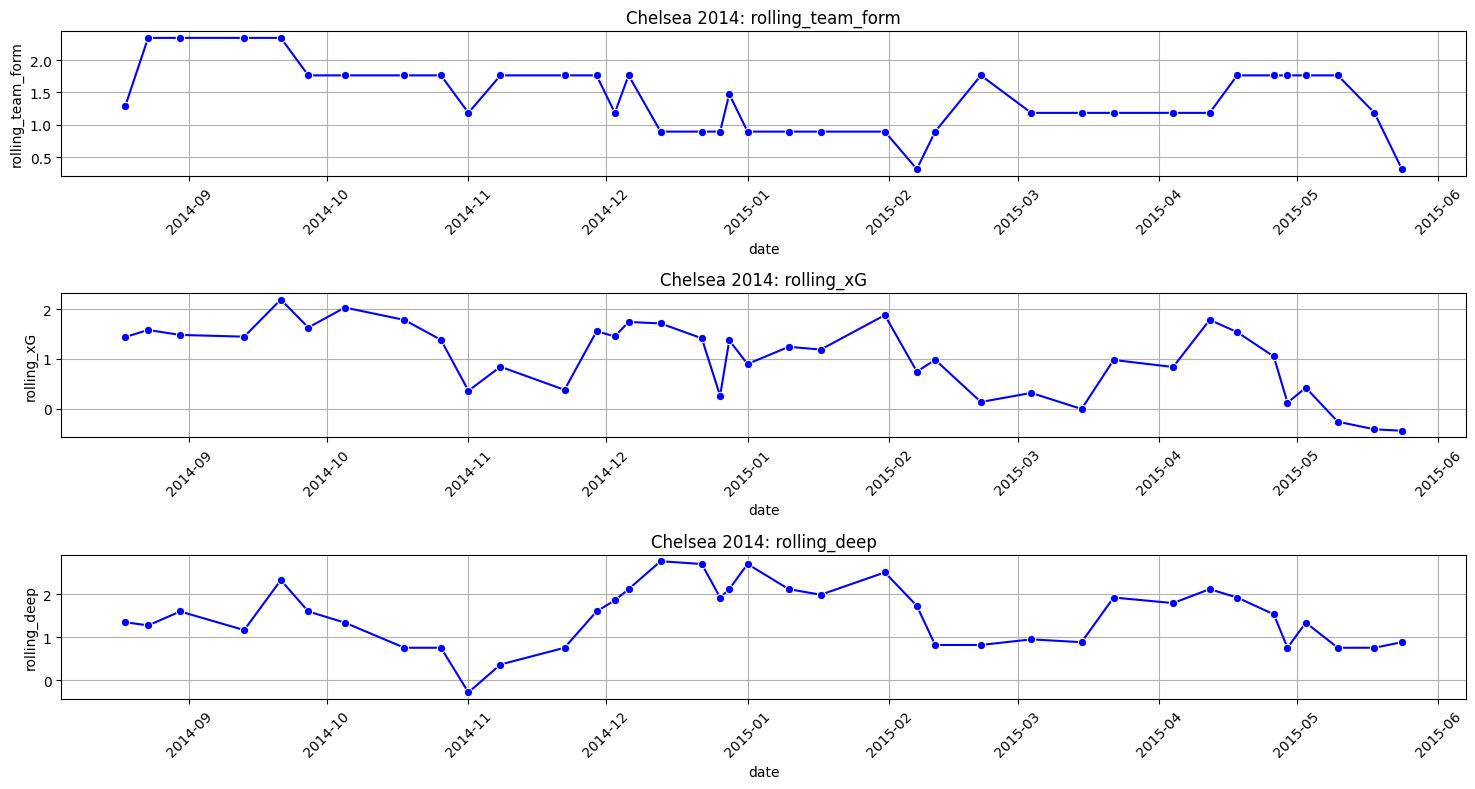

In [225]:

team_data = final_train_df[(final_train_df['team']== "Chelsea") & (final_train_df['season']== 2014)].sort_values(by='date')

plt.figure(figsize=(15, 8))  # Single figure with subplots

for i, feature in enumerate(['rolling_team_form', 'rolling_xG', 'rolling_deep'], 1):
    plt.subplot(3, 1, i)  # 3 rows, 1 column, position i
    sns.lineplot(data=team_data, x='date', y=feature, marker='o', color='blue')
    plt.title(f"Chelsea 2014: {feature}")
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()  # Prevent overlapping labels
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

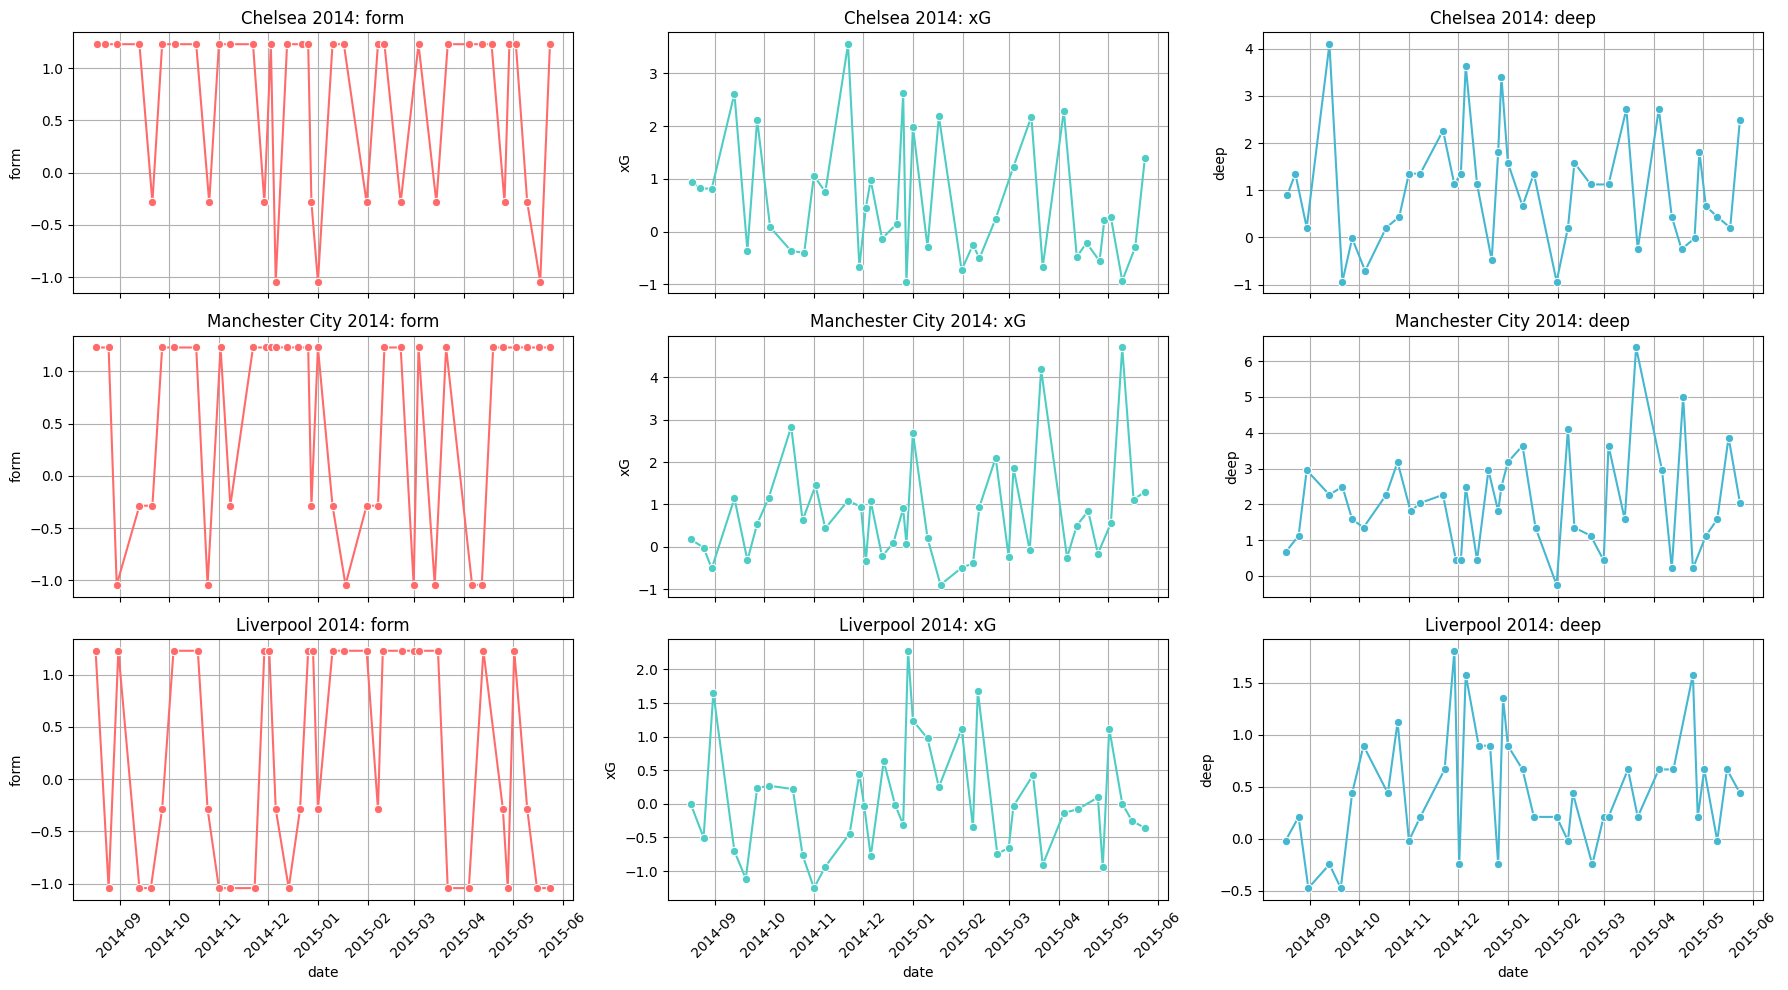

Infinite values in numeric columns:
form                              0
xG                                0
shot_accuracy                     0
deep                              0
rolling_team_form                 0
rolling_xG                        0
rolling_shot_accuracy             0
rolling_deep                      0
opponent_xG                       0
opponent_shot_accuracy            0
opponent_deep                     0
opponent_rolling_team_form        0
opponent_rolling_xG               0
opponent_rolling_shot_accuracy    0
opponent_rolling_deep             0
is_home                           0
is_newly_promoted                 0
total_points                      0
season                            0
league_id                         0
dtype: int64


In [226]:

# Define teams and features to compare
teams = ["Chelsea", "Manchester City", "Liverpool"]  # Add more teams if needed
features = ['form', 'xG', 'deep']
season = 2014

# Set up subplots: 1 row per team, 3 columns per feature
fig, axes = plt.subplots(len(teams), len(features), figsize=(18, 10), sharex=True)

for i, team in enumerate(teams):
    # Filter team data for the season
    team_data = final_train_df[
        (final_train_df['team'] == team) & 
        (final_train_df['season'] == season)
    ].sort_values(by='date')
    
    for j, feature in enumerate(features):
        ax = axes[i, j]
        sns.lineplot(
            data=team_data, 
            x='date', 
            y=feature, 
            ax=ax,
            marker='o',
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'][j]  # Different colors per feature
        )
        ax.set_title(f"{team} {season}: {feature}")
        ax.set_ylabel(feature)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

plt.tight_layout()
plt.show()

# Check for infinite values (unchanged from your code)
numeric_cols = final_train_df.select_dtypes(include=[np.number]).columns
inf_counts = (np.isinf(final_train_df[numeric_cols])).sum()
print("Infinite values in numeric columns:")
print(inf_counts)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

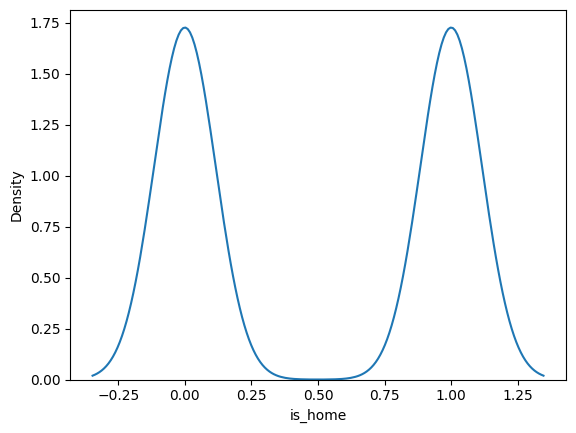

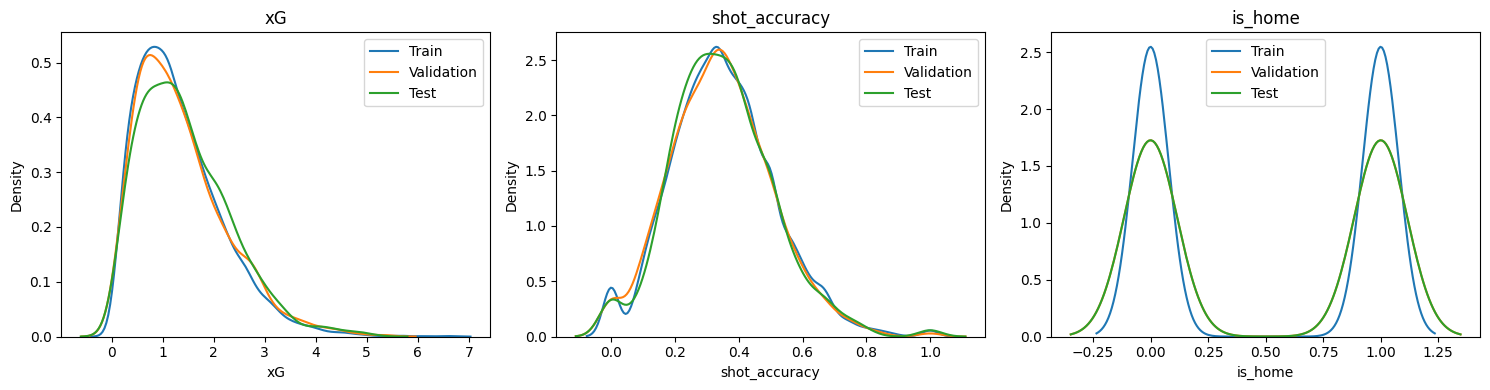

In [227]:
def plot_feature_distributions(features=['xG', 'shot_accuracy', 'is_home']):
    """Compare feature distributions across train/val/test sets"""
    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i+1)
        sns.kdeplot(train_df[feature], label='Train')
        sns.kdeplot(val_df[feature], label='Validation')
        sns.kdeplot(test_df[feature], label='Test')
        plt.title(feature)
        plt.legend()
    plt.tight_layout()
    plt.show()
sns.kdeplot(val_df['is_home'], label='Validation')
plot_feature_distributions()

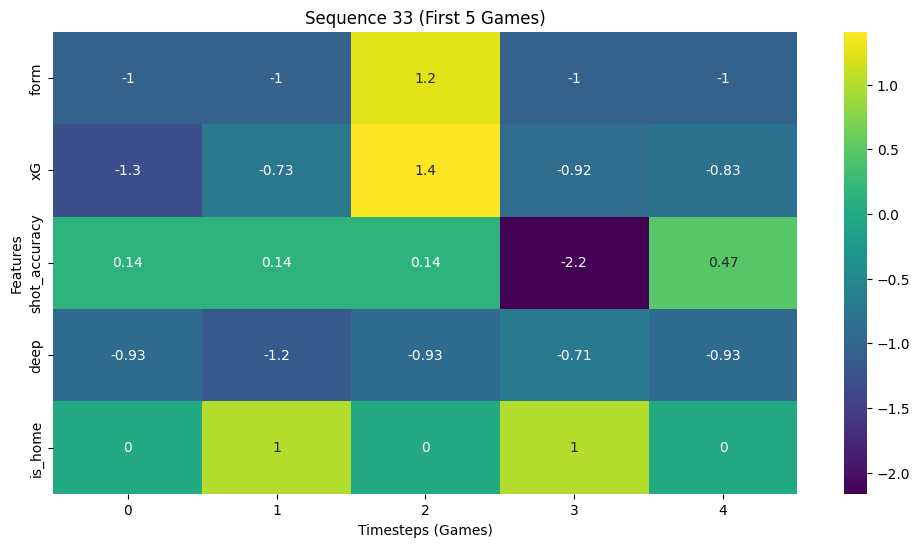

In [228]:
def plot_sequence(sequence_idx, max_timesteps=10, n_features=5):
    """Plot first N timesteps of a sample sequence"""
    plt.figure(figsize=(12, 6))
    
    # Get first sequence (padded)
    sample_seq = X_train[sequence_idx][:max_timesteps, :n_features]
    
    # Create heatmap
    sns.heatmap(sample_seq.T, annot=True, cmap='viridis', 
                yticklabels=feature_cols[:n_features])
    plt.title(f"Sequence {sequence_idx} (First {max_timesteps} Games)")
    plt.xlabel("Timesteps (Games)")
    plt.ylabel("Features")
    plt.show()

# Example: First sequence, first 5 features
plot_sequence(33, max_timesteps=5, n_features=5)

In [229]:
print("Training mean:", scaler.mean_[:5])  # First 5 features' means
print("Training std:", scaler.scale_[:5])  # First 5 features' std devs

# Check test data didn't influence scaling
assert np.allclose(scaler.mean_, train_df[scale_features].mean()), "Data leakage!"

Training mean: [1.37678571 1.33017269 0.35163982 6.08486842 1.38378549]
Training std: [1.31983374 0.85486179 0.16255387 4.37343274 0.69008868]


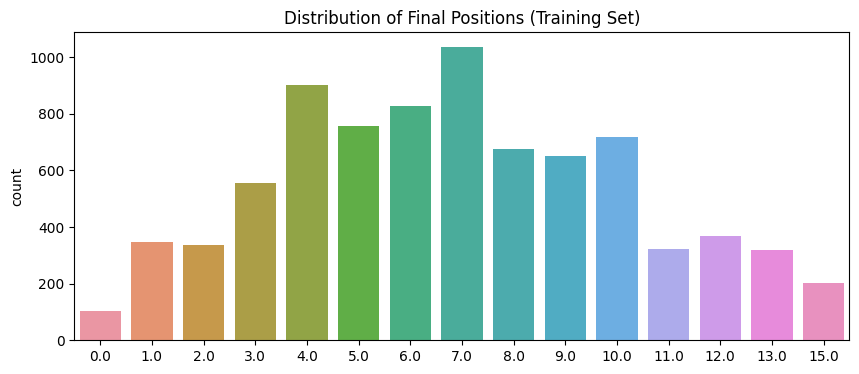

In [230]:
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train)
plt.title("Distribution of Final Positions (Training Set)")
plt.show()

In [231]:
X_train.shape

(8120, 5, 18)

In [232]:
print("y_train:", y_train[:35])
print("\nUnique targets:", np.unique(y_train))# Check possible positions (e.g., 1-20)
y_train.shape

y_train: [ 8.  7.  5.  4.  4.  4.  4.  6.  7.  8.  8.  9.  6.  6.  6.  6.  5.  8.
 10.  9.  7. 10. 10.  7.  7.  6.  6.  4.  5.  0.  3.  3.  3.  3.  6.]

Unique targets: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 15.]


(8120,)

In [233]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

m = X_train.shape[0]
time_steps = X_train.shape[1]
n = X_train.shape[2]

In [234]:
print("Last timestep (shouldnt be 0):", X_train[0][-1, :3])  # First 3 features

Last timestep (shouldnt be 0): [-1.04315087 -1.25230499 -1.39424532]


In [ ]:
model = Sequential([
    LSTM(64, 
         input_shape=(time_steps, n),  # Input shape defined here
         return_sequences=False, 
         kernel_regularizer=l2(0.01)),  # L2 regularization with λ=0.01
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

model.compile(
    optimizer= Adam(learning_rate=0.001),
    loss = 'mse',
    metrics = ['mae', 'mse']
)

model.summary()

os.makedirs('/kaggle/working/checkpoints', exist_ok=True)

# using EarlyStopping and ModelChekpoint callbacks

early_stopping = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint(
    
    filepath='/kaggle/working/checkpoints/model_epoch{epoch:02d}.keras',
    monitor='val_mae',
    save_best_only=False,
    save_weights_only=False,
    mode='min',
    verbose=1,
    
)

#Model training
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=3,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_improved_lstm_model(input_shape):
    model = Sequential()
    
    # 1st LSTM Layer with regularization
    model.add(
        Bidirectional(  # Capture both forward/backward patterns
            LSTM(128, 
                return_sequences=True,  # Pass sequences to next layer
                kernel_regularizer=l2(0.001),
                recurrent_dropout=0.2,  # Regularize internal connections
                input_shape=input_shape)
        )
    )
    model.add(Dropout(0.4))  # External dropout
    
    # 2nd LSTM Layer (many-to-one)
    model.add(
        LSTM(64, 
            return_sequences=False,  # Final sequence step only
            kernel_regularizer=l2(0.001),
            recurrent_dropout=0.1)
    )
    model.add(Dropout(0.3))
    
    # Dense layers with regularization
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, kernel_regularizer=l2(0.001)))  # Single regression output
    
    optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Add these callbacks to your fit() call
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Usage:
model = build_improved_lstm_model(input_shape=(time_steps, n))
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Let early stopping decide actual epochs
    batch_size=64,  # Larger batch for stability
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,361 (91.25 KB)

 Trainable params: 23,361 (91.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
2703/2707 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.4149 - mae: 2.2455 - mse: 10.0958
Epoch 1: saving model to /kaggle/working/checkpoints/model_epoch01.keras
2707/2707 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 10.4047 - mae: 2.2443 - mse: 10.0856 - val_loss: 2.3275 - val_mae: 1.2064 - val_mse: 2.1074
Epoch 2/1000
2707/2707 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6294 - mae: 1.2859 - mse: 2.4267
Epoch 2: saving model to /kaggle/working/checkpoints/model_epoch02.keras
2707/2707 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.6294 - mae: 1.2859 - mse: 2.4267 - val_loss: 1.9704 - val_mae: 1.1569 - val_mse: 1.8014
Epoch 3/1000
2703/2707 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5198 - mae: 1.2770 - mse: 2.3600
Epoch 3: saving model to /kaggle/working/checkpoints/model_epoch03.keras
2707/2707 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.5197 - mae: 1.2770 - mse: 2.3598 - val_loss: 2.0585 - val_mae: 1.1856 - val_mse: 1.9156
Epoch 4/1000
2697/2707 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste